In [40]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tinydb import TinyDB

from nlg_data import util
from nlg_data.models import Experiment

data_folder = Path("../data")
db_path = data_folder / "db.json"
db = TinyDB(db_path)

game = util.get_game_by_name(db, "G14")
game

NonlocalGame(id=UUID('a820d903-1834-4ab1-8679-2d9c888306a5'), name='G14', optimal_classical_value=0.9772727272727273, optimal_quantum_value=1.0, publication=Publication(citation='L. Mančinska and D. E. Roberson, Baltic Journal on Modern Computing, 4(4), 846-859, 2016', url=Url('https://arxiv.org/abs/1801.03542')), tags=['graph-coloring'], objects=[Object(name='graph', description='NetworkX definition of the G14 graph', path=WindowsPath('games/g14/g14.nx'))])

In [41]:
from tinydb import Query


Exp = Query()
HasCounts = Exp.attributes['has_counts'] == True
docs = db.table("experiments").search(HasCounts)
len(docs)

38

In [42]:
import itertools
from dataclasses import dataclass
from collections import Counter

import networkx as nx
import numpy as np
from scipy.spatial.distance import jensenshannon

from nlg_data.models import Result

def _marginalize(dist: dict[tuple[int, ...], int], idx: int) -> dict[int, int]:
    new_dist = Counter()
    for k, v in dist.items():
        new_dist[k[idx]] += v
    
    return new_dist

@dataclass(frozen=True, eq=True)
class MarginalConstraint:
    player_index: int
    group: frozenset[tuple[int, ...]]

    def evaluate(self, result: Result):
        G = nx.Graph()
        dists = {tuple(r.circuit): r.counts for r in result.results if r.counts is not None}
        for x1, x2 in itertools.combinations(self.group, 2):
            d1 = _marginalize(dists[x1], self.player_index)
            d2 = _marginalize(dists[x2], self.player_index)

            # Make the supports match, then project each to a numpy array
            support = list(set(d1) | set(d2))
            p1 = np.array([d1.get(a, 0) for a in support])
            p2 = np.array([d2.get(a, 0) for a in support])
            val = jensenshannon(p1, p2, base=2) ** 2 # square bc scipy uses sqrt
            G.add_node(self.friendly_name(x1), marginal=self)
            G.add_node(self.friendly_name(x2), marginal=self)
            G.add_edge(self.friendly_name(x1), self.friendly_name(x2), weight=val)

        return G

    def friendly_name(self, query: tuple[int, ...]) -> str:
        given_vars = ",".join(map(str, query))
        return f"p(a{self.player_index}|{given_vars})"

    def compact_name(self) -> str:
        first_query = list(self.group)[0]
        xi = first_query[self.player_index]
        return f"$p(a_{self.player_index}|x_{self.player_index}={xi})$"

    def __str__(self):
        query_strs = map(self.friendly_name, self.group)
        return " = ".join(query_strs)

def evaluate_marginals(experiment: Experiment) -> nx.Graph:
    # The df should have columns x0, ..., xn, a0, ..., an, counts
    result_path = data_folder / experiment.circuit_data.result_path
    result = Result.model_validate_json(result_path.read_text())
    df = result.df

    query_cols = sorted([c for c in df.columns if c.startswith('x')])
    n_players = len(query_cols)
    queries: set[tuple[int, ...]] = set(zip(*[df[c].array for c in query_cols]))

    # Step 1: Create a set of all marginals to evaluate. Each element of group will be
    # a tuple of queries {x0, x1, ...} that match at some particular index i. Which
    # means then we'll check that p(ai | x0) = p(ai | x1) = ...
    groups: set[MarginalConstraint] = set()
    for x in queries:
        for i in range(n_players):
            equivalent_queries = frozenset(xp for xp in queries if xp[i] == x[i])
            groups.add(MarginalConstraint(i, equivalent_queries))
    
    # Create the graph for each marginal group, then merge them
    graphs = list(map(lambda m: m.evaluate(result), groups))
    G = graphs.pop()
    for H in graphs:
        G = nx.compose(G, H)

    return G

In [43]:
import asyncio
from concurrent.futures import ThreadPoolExecutor

experiments = [Experiment(**d) for d in docs]
loop = asyncio.get_running_loop()

futures = []
with ThreadPoolExecutor() as pool:
    for exp in experiments:
        futures.append(loop.run_in_executor(pool, evaluate_marginals, exp))

results = await asyncio.gather(*futures)

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

def marginal_to_df(G: nx.Graph, exp: Experiment):
    records = []
    for comp in nx.connected_components(G):
        subG: nx.Graph = nx.induced_subgraph(G, comp)
        comp = list(comp)
        vals = [w for *_, w in subG.edges(data="weight")]

        node = comp[0]
        m: MarginalConstraint = subG.nodes.data("marginal")[node]
        
        for i, v in enumerate(vals):
            records.append({
                'eq': m.compact_name(),
                'trial': i,
                'js': v
            })

    data = pd.DataFrame.from_records(records)
    data.sort_values('eq', inplace=True)
    return data

def plot_marginal(G: nx.Graph, exp: Experiment):
    data = marginal_to_df(G, exp)
    fig = plt.figure(figsize=(8, 10), dpi=300)
    ax = fig.gca()
    sns.stripplot(data, x="js", y="eq", ax=ax, hue="eq", legend=False)
    plt.title(f"Marginal divergences ({exp.device.provider}-{exp.device.name})")
    plt.xlabel(r"$D_{JS}(P||Q)$ [bits]")
    plt.ylabel("Constraint")
    plt.show()

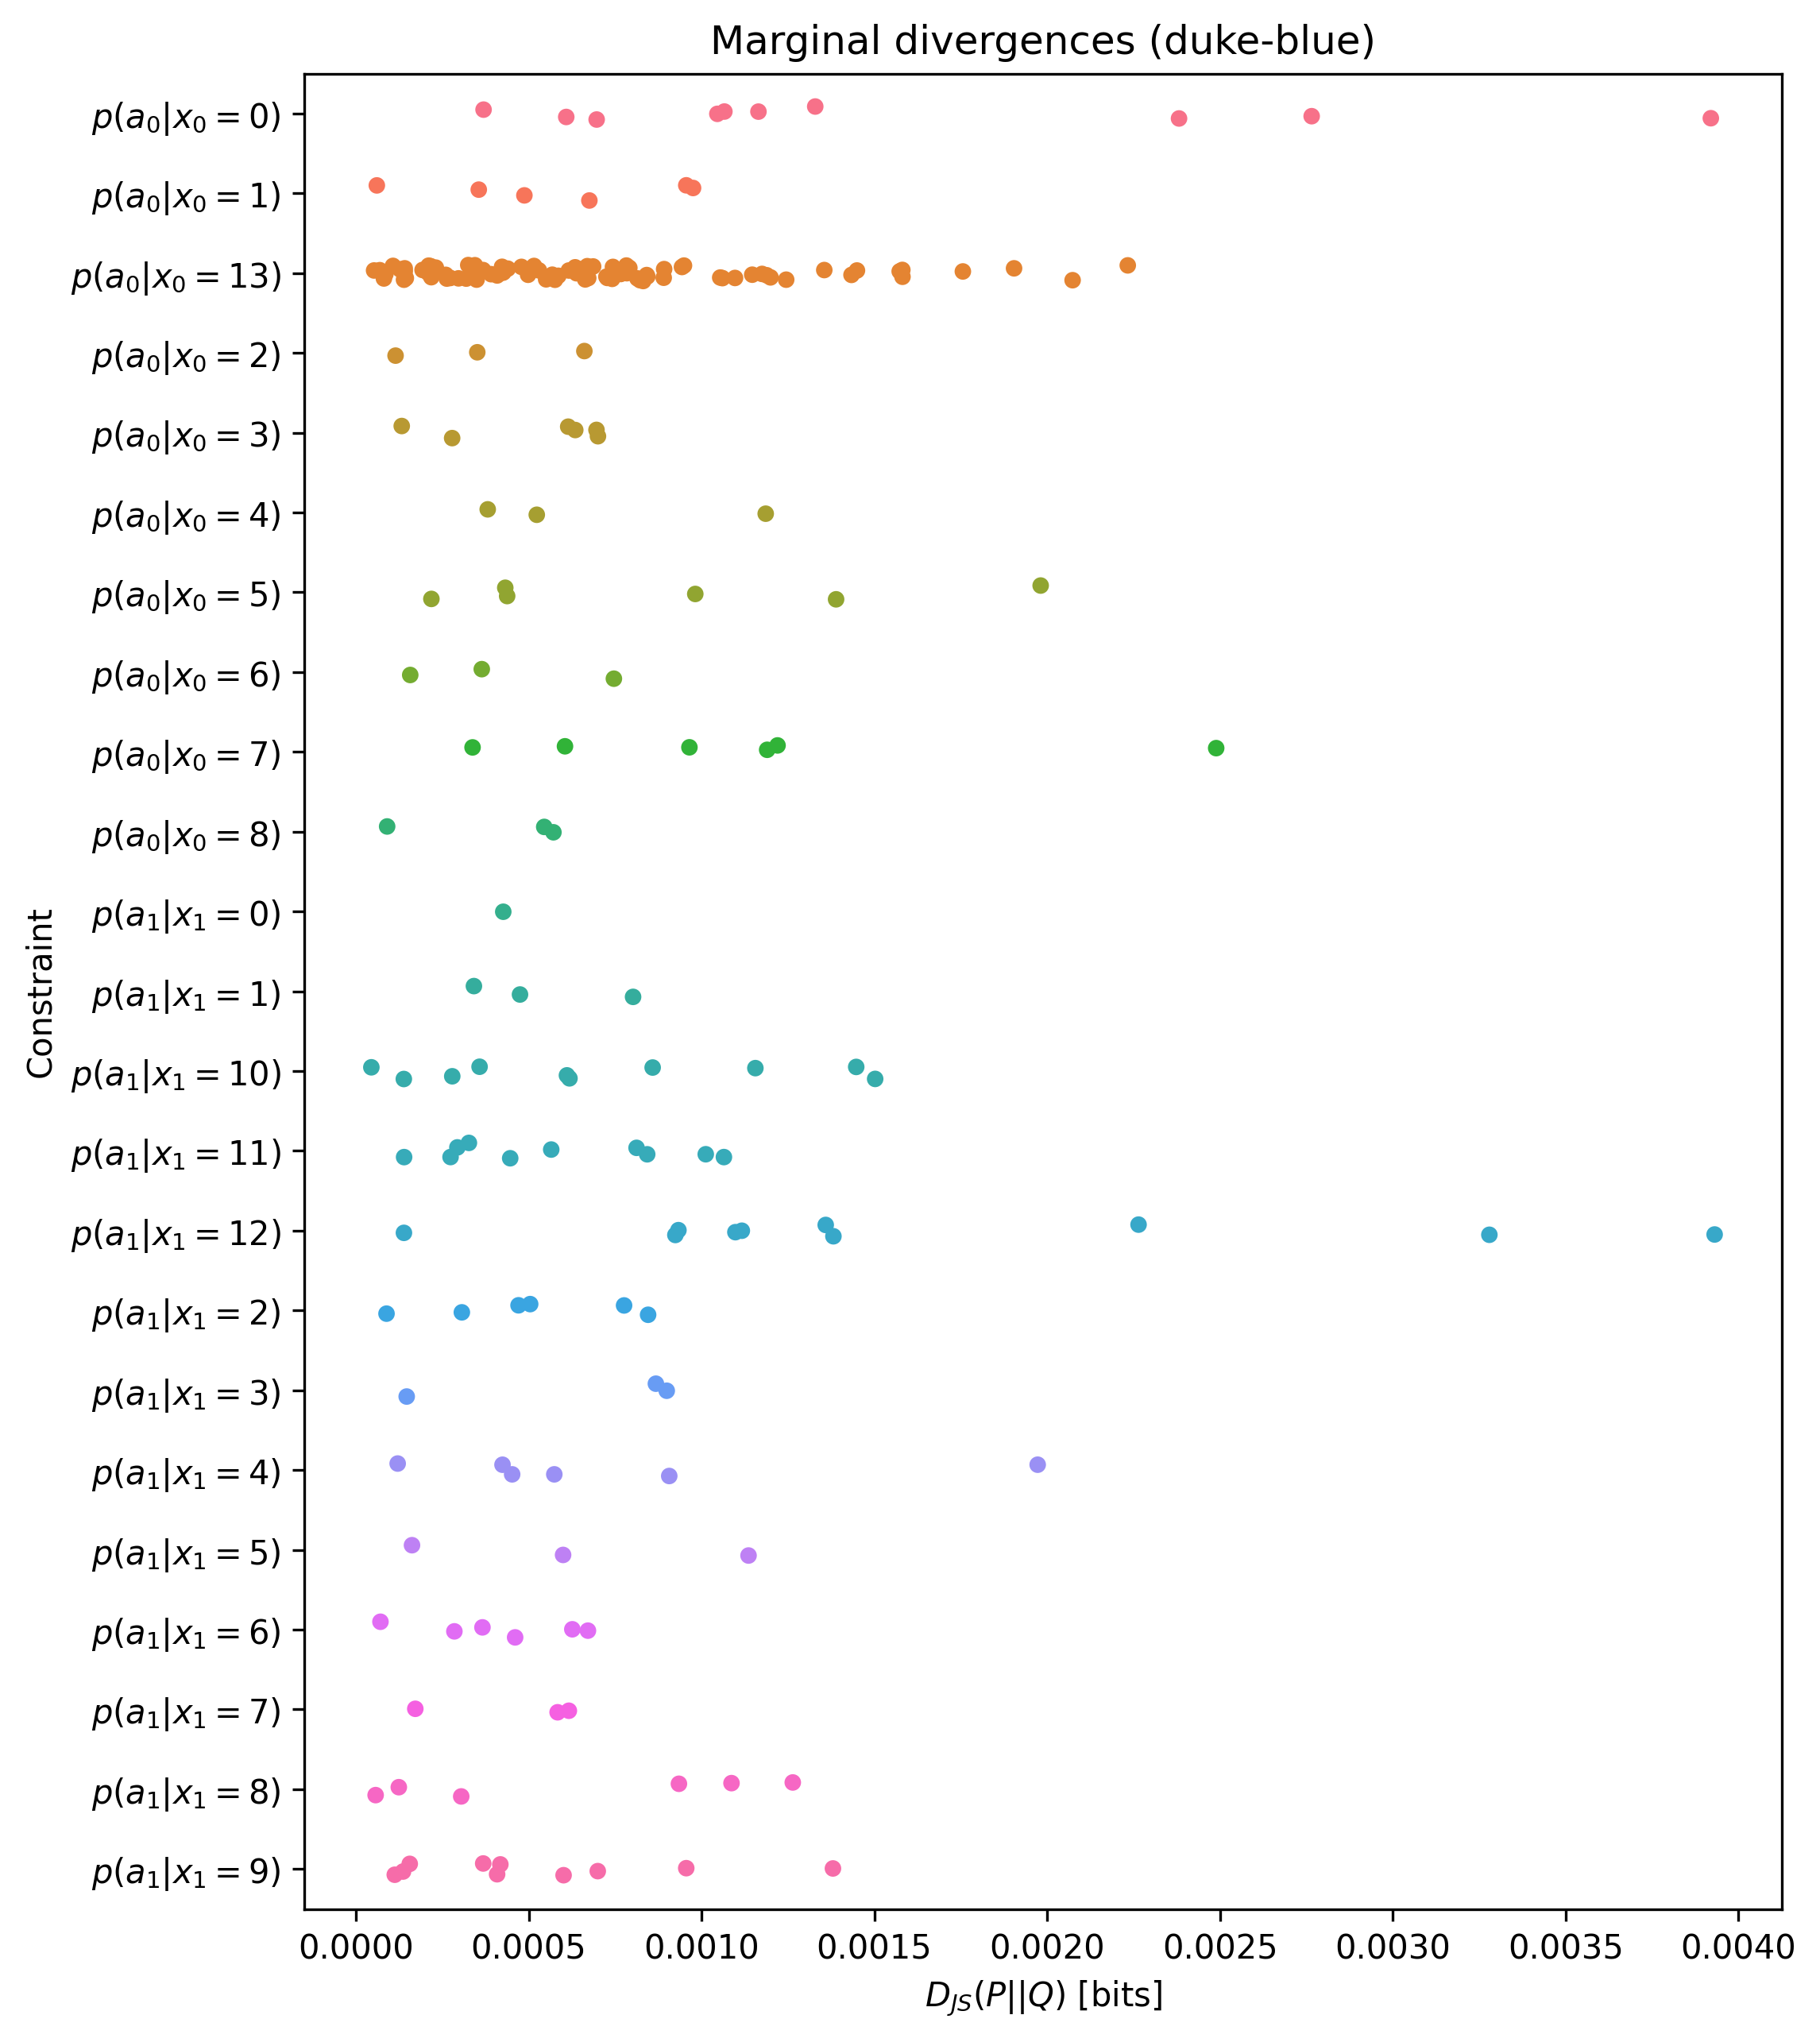

In [82]:
exp = next(filter(lambda e: e.device.name == 'blue', experiments))
idx = experiments.index(exp)
G = results[idx]
plot_marginal(G, exp)

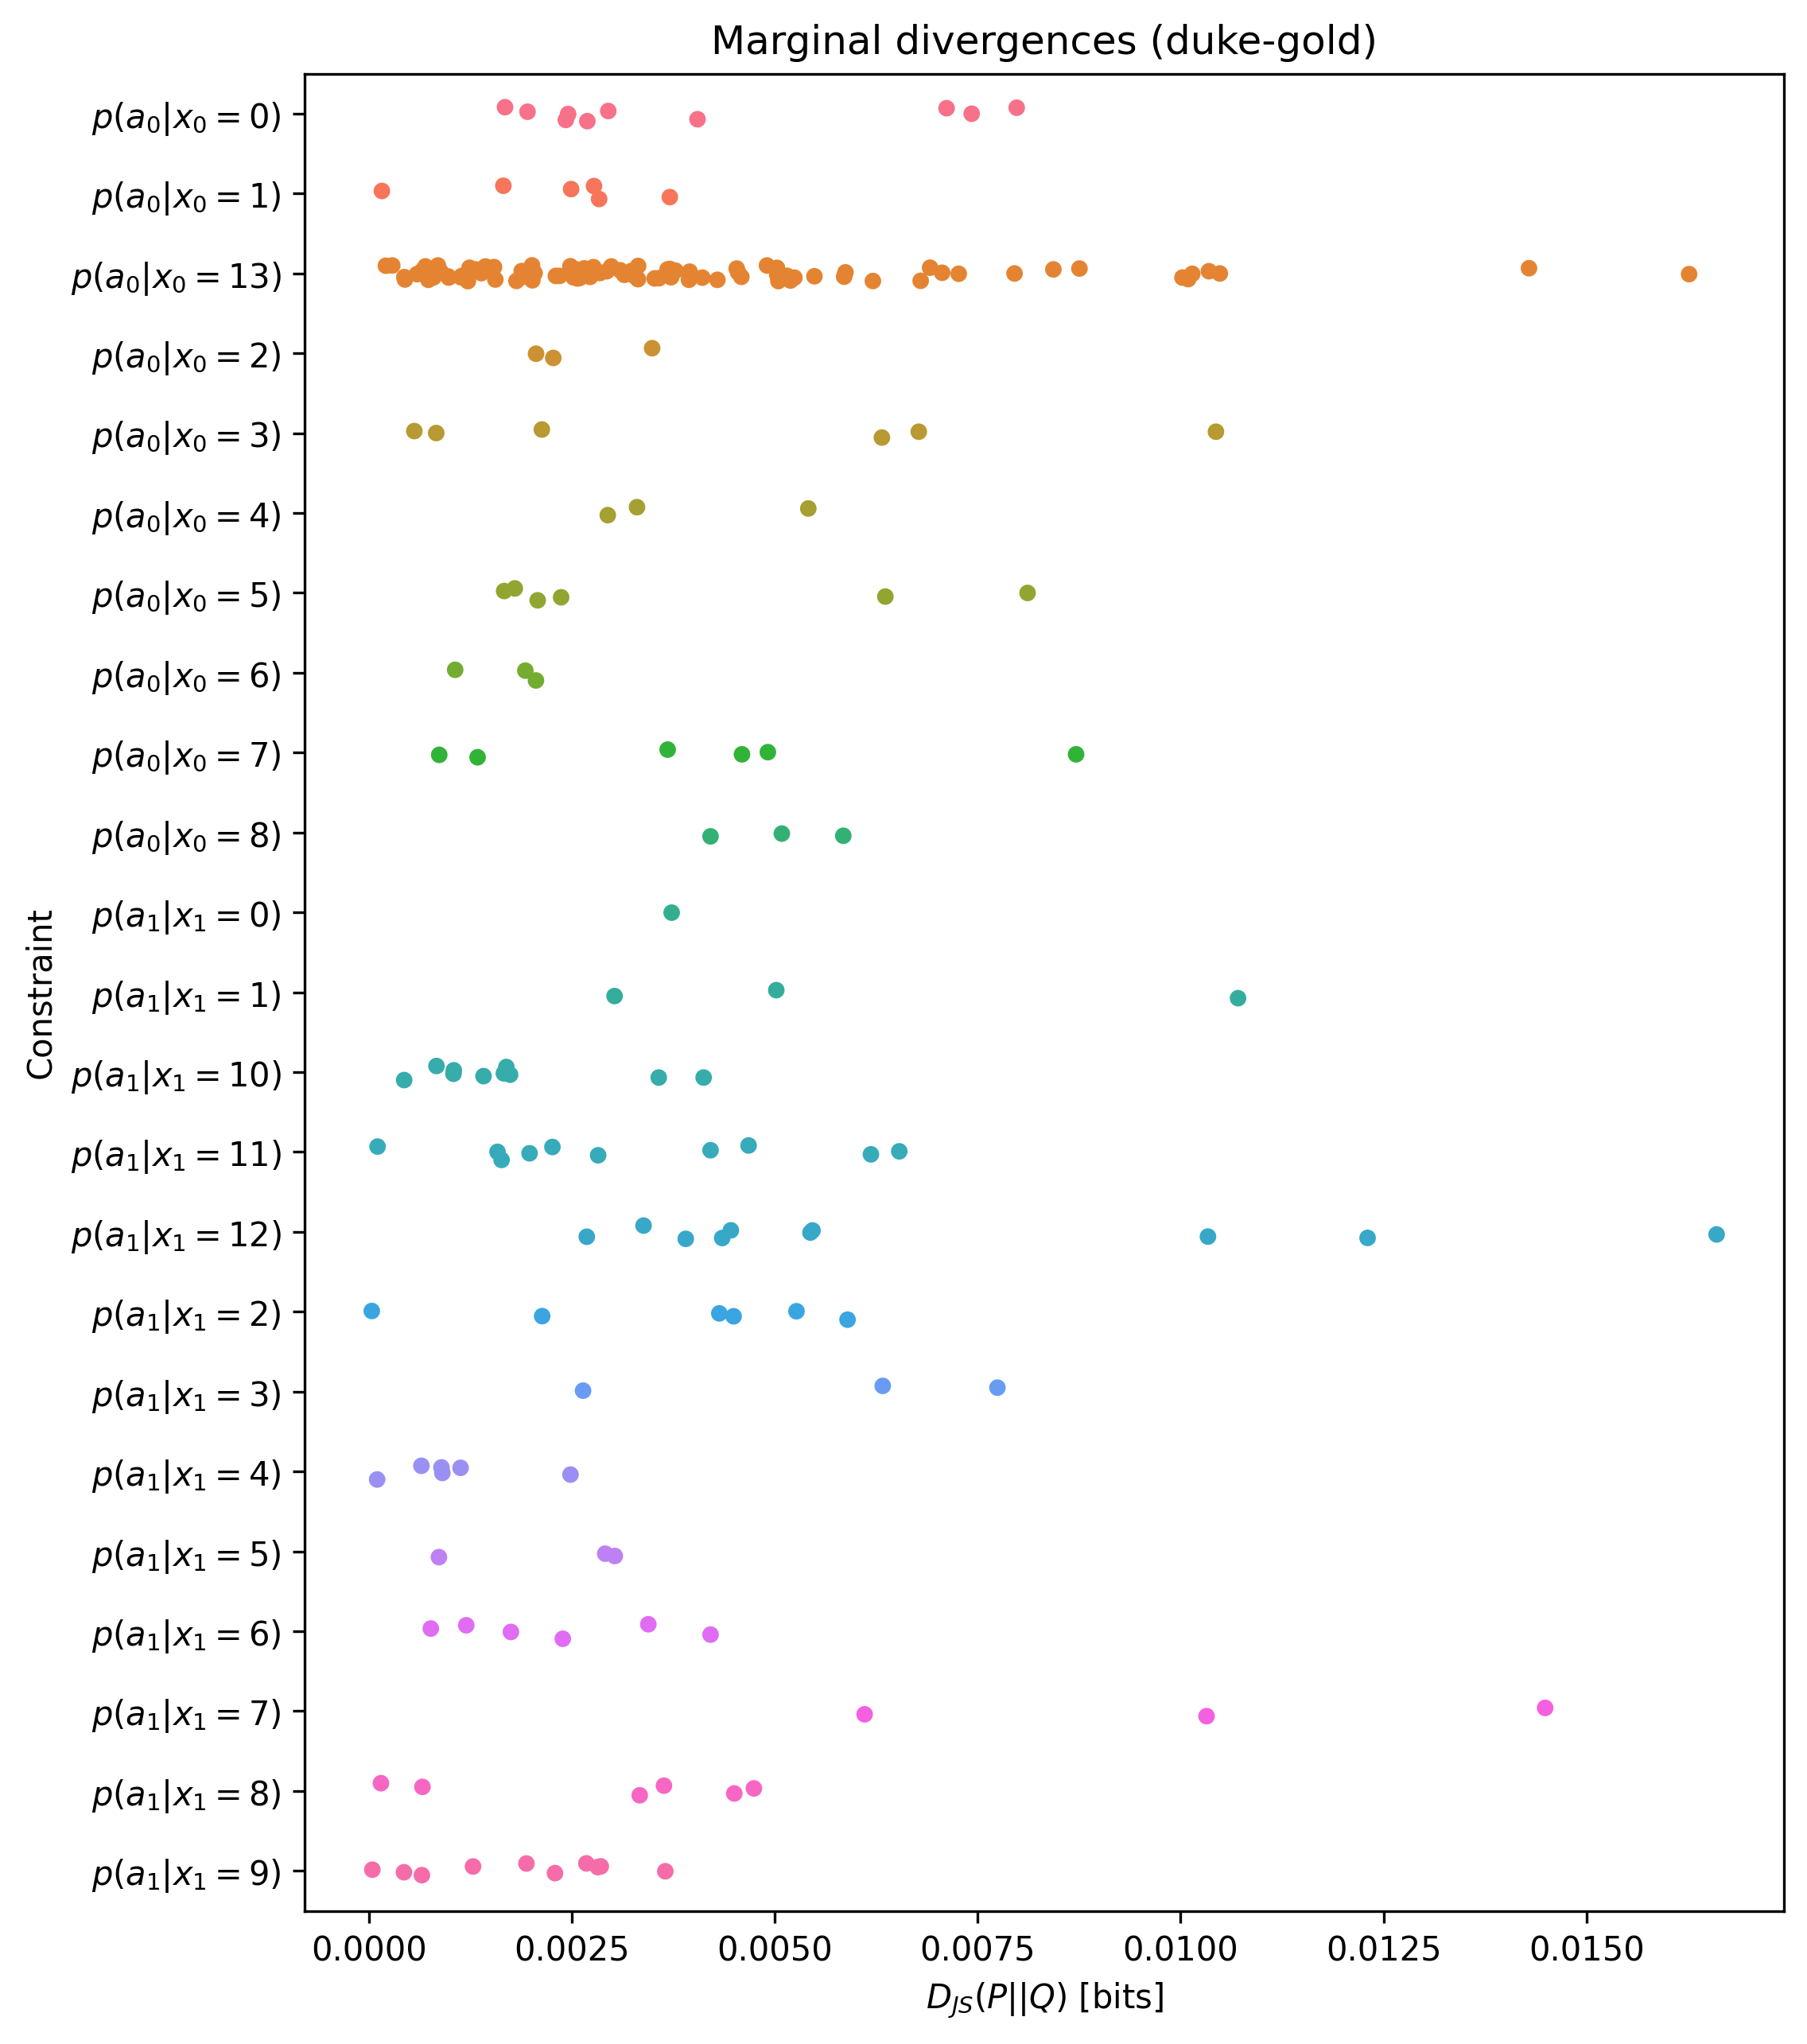

In [83]:
exp = next(filter(lambda e: e.device.name == 'gold', experiments))
idx = experiments.index(exp)
G = results[idx]
plot_marginal(G, exp)

In [75]:
IsBellPair = Exp.circuit_data.strategy == "bell_pair"
HasCounts = (Exp.attributes.has_counts == True)
IsTrappedIon = (Exp.device.type == "trapped-ion")
IsSherbrooke = Exp.device.name == "sherbrooke"
docs = db.table("experiments").search(HasCounts & IsBellPair & (IsTrappedIon | IsSherbrooke))

df = pd.DataFrame()
for exp_doc in docs:
    exp = Experiment(**exp_doc)
    G = evaluate_marginals(exp)
    new_df = marginal_to_df(G, exp)
    new_df['device'] = exp.device.name
    df = pd.concat([df, new_df])

df

,eq,trial,js,device
213,$p(a_0|x_0=0)$,9,0.002691,gold
211,$p(a_0|x_0=0)$,7,0.004048,gold
210,$p(a_0|x_0=0)$,6,0.007426,gold
209,$p(a_0|x_0=0)$,5,0.002426,gold
208,$p(a_0|x_0=0)$,4,0.007980,gold
...,...,...,...,...
294,$p(a_1|x_1=9)$,3,0.000225,sherbrooke
293,$p(a_1|x_1=9)$,2,0.000128,sherbrooke
292,$p(a_1|x_1=9)$,1,0.000331,sherbrooke
291,$p(a_1|x_1=9)$,0,0.000478,sherbrooke


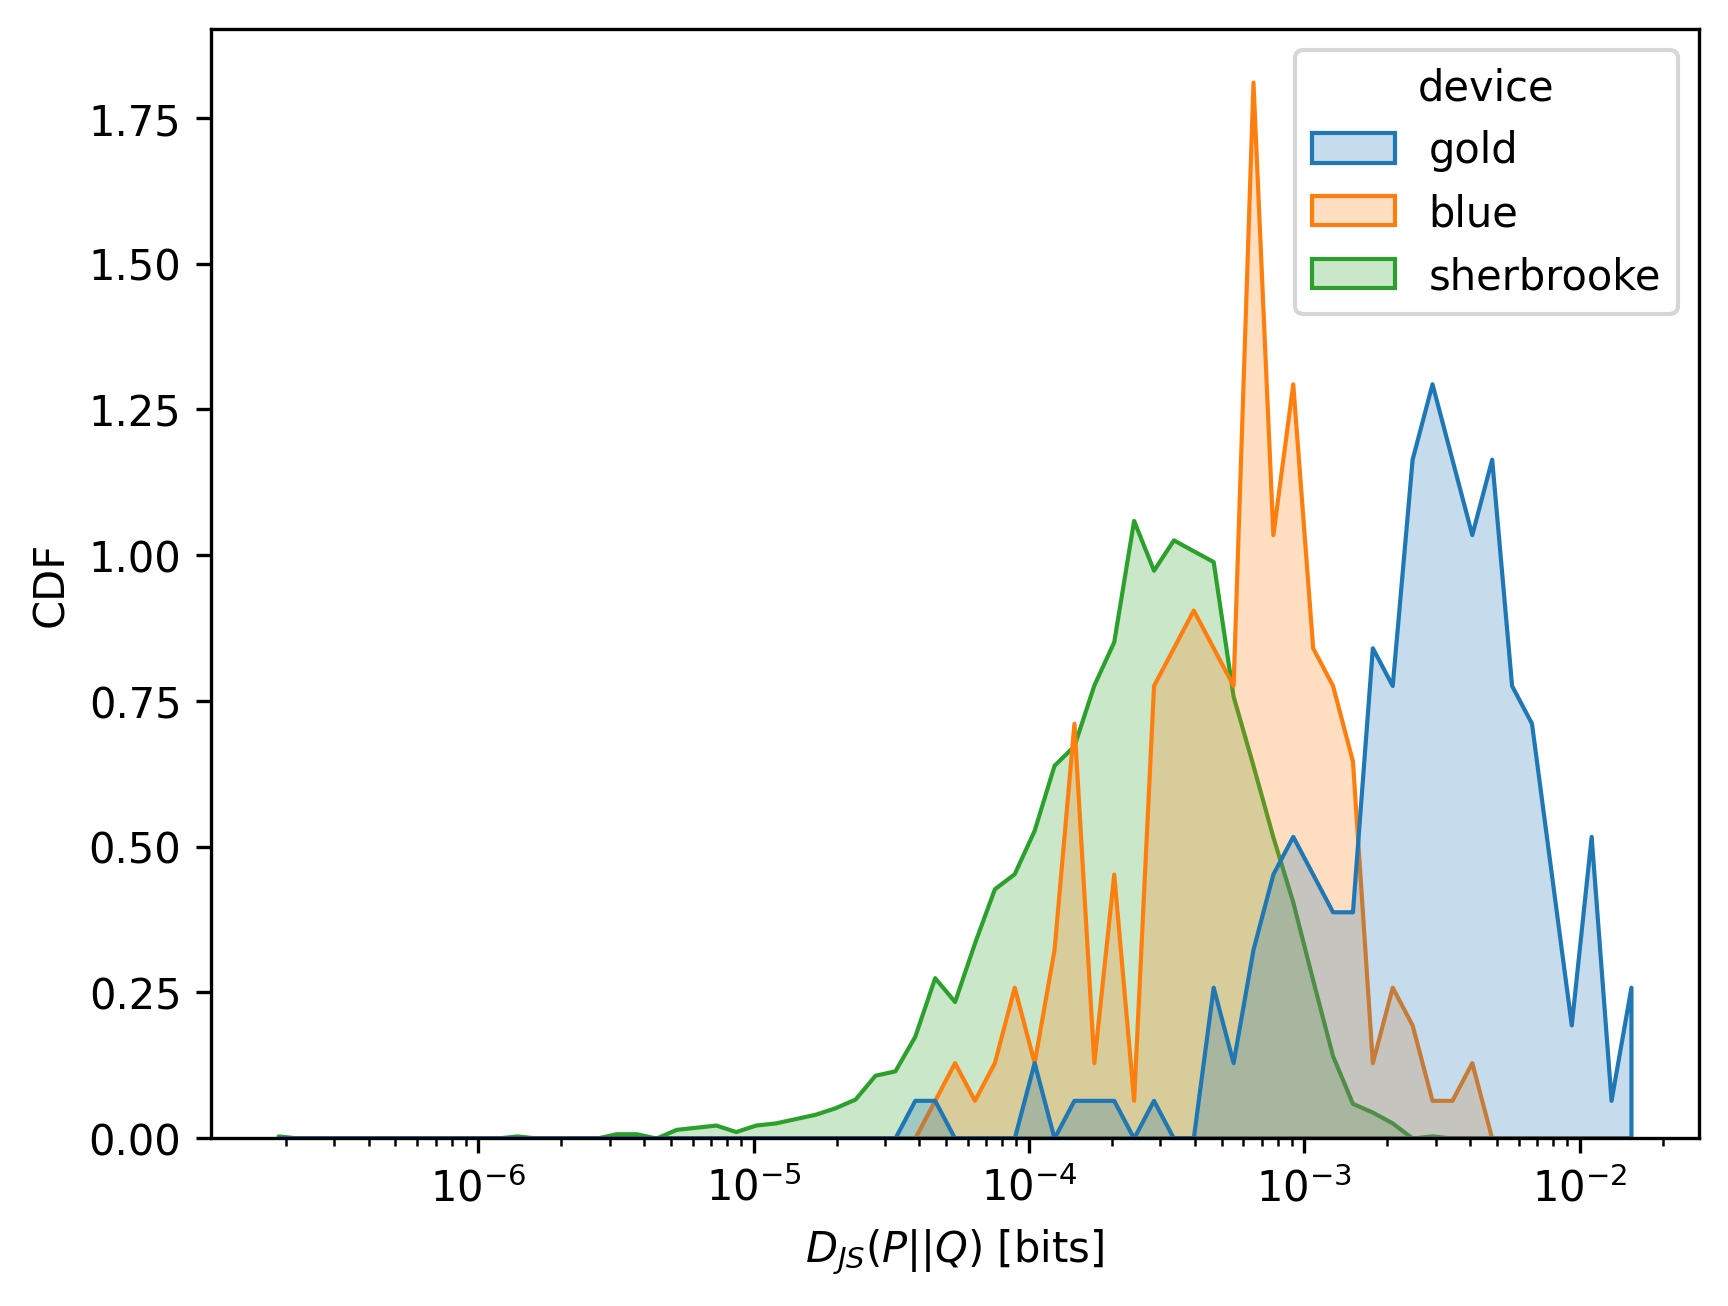

In [78]:
plt.figure(dpi=300)
sns.histplot(
    df,
    x="js",
    hue="device",
    stat="density",
    log_scale=True,
    fill=True,
    # cumulative=True,
    element="poly", common_norm=False, common_bins=True
)
plt.xlabel(r"$D_{JS}(P||Q)$ [bits]")
plt.ylabel("CDF")
plt.show()

### PBR Protocol

For an observed behavior $\vec{P}(a|x)$ where (with slight abuse of notation) $a = (a, b, \dots)$ and $x = (x, y, \dots)$, we'd like to test the consistency of the null hypothesis $\mathcal{H}_0 = \vec{P} \in \mathcal{NS}$. The steps are as follows

**Fit** First, from our observed frequencies $\vec{f}(a|x) := N(a,x) / N(x)$, we minimize the following problem
$$P^*_{\mathcal{NS}} = \min_{P \in \mathcal{NS}} D_{KL}(f||P)$$
This gives us the closest distribution in $\mathcal{NS}$ to our experimental data. To constrain $P \in \mathcal{NS}$, one uses the following linear constraints:

$$\mathcal{NS}_{B \nrightarrow A} := \sum_b P(a, b|x, y) = \sum_b(a, b|x, y')$$
$$\mathcal{NS}_{A \nrightarrow B} := \sum_a P(a, b|x, y) = \sum_a(a, b|x', y)$$

The class $\mathcal{NS} = \mathcal{NS}_{B \nrightarrow A} \cap \mathcal{NS}_{A \nrightarrow B}$ is the combination of those constraints.

From this, we can now compute the value

$$R(a,x) := \frac{\vec{f}(a|x)}{P_{\mathcal{NS}}^*(a|x)}$$

**Test** Given some new data $\mathcal{D} = \{(x_1, a_1), \dots, (x_n, a_n)\}$, we compute the statistic

$$t = \prod_{x,a \in \mathcal{D}} R(a,x)$$

and the upper bound p-value is given by $p_U = \min(t^{-1}, 1)$.

In [92]:
import itertools
from collections import Counter
from typing import Optional

import cvxpy as cp
import numpy as np
from sklearn.base import BaseEstimator


class NonSignalingRegression(BaseEstimator):
    def __init__(self, players: int, questions: int, answers: int, P_x: np.ndarray | None = None):
        if players > 2:
            raise NotImplementedError("No support yet for more than 2 players")
        
        self.players = players
        self.questions = questions
        self.answers = answers

        shape = self.players*(self.questions,)

        # If not provided, assume all questions asked uniformly
        if P_x is None:
            P_x = np.ones(shape)
            P_x /= P_x.size
        else:
            if P_x.shape != shape:
                raise ValueError(f"Expected input distribution P(x) with shape {shape}, got {P_x.shape}")
            
        self.P_x = P_x
        self._kl_div = 0
        self._R: np.ndarray = None
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None):
        # X should be rows of the form (x, y, a, b)
        if X.ndim != 2 or X.shape[1] != 2 * self.players:
            raise ValueError(f"Expected sample array of shape (n, 2*players), got: {X.shape}")

        # Sparse structure: only store distribution for values we can actually get
        query_set = set(tuple(map(int, x)) for x in zip(*self.P_x.nonzero()))
        self._query_to_idx = {k: i for i, k in enumerate(query_set)}

        answer_set: set[tuple[int, ...]] = set(itertools.product(range(self.answers), repeat=self.players))
        self._answer_to_idx = {k: i for i, k in enumerate(answer_set)}

        # Obtain the (normalized) frequencies f(a|x)
        f_xa_dict = self._get_frequencies(X)
        
        # Convert frequencies to an array
        shape = (len(query_set), len(answer_set))
        f_xa = np.zeros(shape, dtype=float)
        for x in query_set:
            for a in answer_set:
                xa = x + a
                f_xa[self._query_to_idx[x], self._answer_to_idx[a]] = f_xa_dict.get(xa, 0)

        # Construct the convex optimization problem, here we assume all questions are equally likely
        P = cp.Variable(shape, nonneg=True)

        P_x = np.zeros((len(query_set), 1))
        nonzero_indices = self.P_x.nonzero()

        for x in zip(*nonzero_indices):
            x = tuple(map(int, x))
            P_x[self._query_to_idx[x]] = self.P_x[*x]

        kl = cp.kl_div(f_xa, P)
        rescaled_kl = cp.multiply(P_x, kl)
        objective = cp.Minimize(cp.sum(rescaled_kl))
        constraints = self._get_constraints(P)
        problem = cp.Problem(objective, constraints)

        # Solve and store the results
        self._kl_div = problem.solve(solver=cp.SCS)
        p_star = P.value
        self._R = f_xa / (p_star + 1e-9)
    
    def predict(self, X: np.ndarray):
        if X.ndim != 2 or X.shape[1] != 2 * self.players:
            raise ValueError(f"Expected sample array of shape (n, 2*players), got: {X.shape}")

        result = np.zeros(X.shape[0])

        # Given samples (x, a), return the values R(x, a)
        for i, row in enumerate(X.astype(int)):
            xa = tuple(map(int, row))
            x, a = xa[:self.players], xa[self.players:]

            # This question was never in our training data
            if (xi := self._query_to_idx.get(x, None)) is None:
                raise ValueError(f"Query {x} was not in training data")
            
            # This pair (x, a) wasn't in the training data, which can happen
            # for low probability pairs. f(a|x) = 0
            elif (ai := self._answer_to_idx.get(a, None)) is None:
                result[i] = 0

            else:
                result[i] = self._R[xi, ai]

        return result
    
    def _get_idx(self, xa: tuple[int, ...]):
        x, a = xa[:self.players], xa[self.players:]

        xi = self._query_to_idx[x]
        ai = self._answer_to_idx[a]
        return xi, ai
        
    def _get_constraints(self, P: cp.Variable):
        constraints: list[cp.Constraint] = []

        query_set = set(self._query_to_idx)
        answer_set = set(self._answer_to_idx)

        # Proper probability sum_{a} p(a|x) = 1
        for x in query_set:
            samples = []
            for a in answer_set:
                xi, ai = self._get_idx(x + a)
                samples.append(P[xi, ai])
            
            constraints.append(cp.sum(samples) == 1)
        
        # No-signaling
        for x1, x2 in itertools.combinations(query_set, 2):
            # From Bob to Alice
            if x1[0] == x2[0]:
                x = x1[0]
                y, y_prime = x1[1], x2[1]
                for a in range(self.answers):
                    samples = [P[*self._get_idx((x, y, a, b))] for b in range(self.answers)]
                    lhs = cp.sum(samples)

                    samples = [P[*self._get_idx((x, y_prime, a, b))] for b in range(self.answers)]
                    rhs = cp.sum(samples)
                    constraints.append(lhs == rhs)
            
            # From Alice to Bob
            elif x1[1] == x2[1]:
                x, x_prime = x1[0], x2[0]
                y = x1[1]
                for b in range(self.answers):
                    samples = [P[*self._get_idx((x, y, a, b))] for a in range(self.answers)]
                    lhs = cp.sum(samples)

                    samples = [P[*self._get_idx((x_prime, y, a, b))] for a in range(self.answers)]
                    rhs = cp.sum(samples)
                    constraints.append(lhs == rhs)

        return constraints

    def _get_frequencies(self, X: np.ndarray):
        raw_samples: list[list[int]] = X.astype(int).tolist()
        N_xa = Counter(map(tuple, raw_samples))

        raw_queries: list[list[int]] = X[..., :self.players].astype(int).tolist()
        N_x = Counter(map(tuple, raw_queries))

        f_xa: dict[tuple[int, ...], float] = {}
        for xa in N_xa:
            x = xa[:self.players]
            f_xa[xa] = N_xa.get(xa, 0) / N_x.get(x, 0)
        
        return f_xa

def pvalue_score(y: np.ndarray):
    # Any entries where y = 0 imply that f(a|x) = 0, which means it wasn't
    # in our training data. Todo: is this the best strategy to handle it?
    log_y = np.log(y[y > 0])
    log_t = log_y.sum()
    t = np.exp(log_t)
    return min(t ** -1, 1)

Fake CHSH data with crosstalk

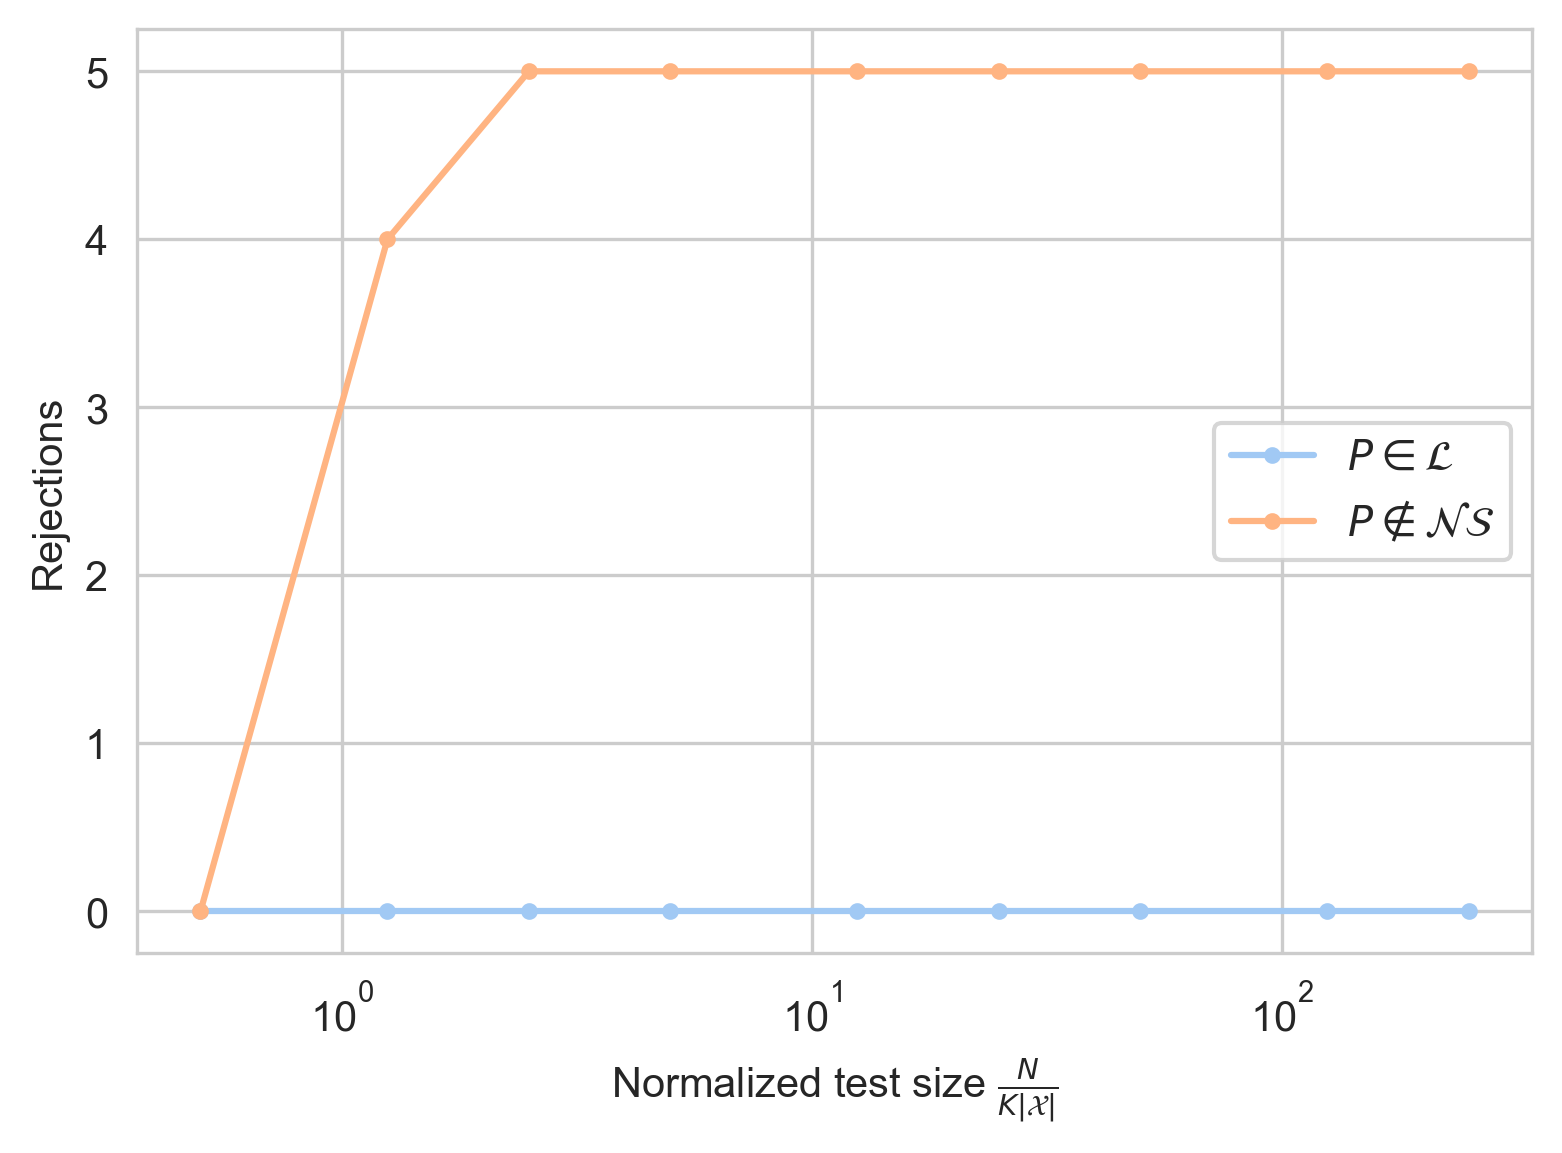

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

def random_chsh_nonsignaling_data(N: int):
    X = np.zeros((N, 4))
    
    # Alice's and Bob's questions are random
    questions = np.random.randint(0, 2, (N, 2))

    # Deterministic classical strategy: a = b = 0
    # (don't need to do anything)

    X[:, :2] = questions
    return X

def random_chsh_signaling_data(N: int):
    X = np.zeros((N, 4))
    
    # Alice's and Bob's questions are random
    questions = np.random.randint(0, 2, (N, 2))
    
    # Alice's answer is random
    alice_answer = np.random.randint(0, 2, (N, 1))
    
    # Bob's answer is a direct copy of Alice's question (x)
    bob_answer = questions[:, 0].reshape(N, 1)
    
    answers = np.hstack([alice_answer, bob_answer])
    
    X[:, :2] = questions
    X[:, 2:] = answers
    
    return X

K = 5
N_vals = np.array([10, 25, 50, 100, 250, 500, 1000, 2500, 5000])
signaling_rejections = np.zeros_like(N_vals)
nonsignaling_rejections = np.zeros_like(N_vals)
for i, N in enumerate(N_vals):
    kf = KFold(n_splits=K)

    X = random_chsh_signaling_data(N)
    for j, (train_indices, test_indices) in enumerate(kf.split(X)):
        model = NonSignalingRegression(2, 2, 2)
        model.fit(X[train_indices])
        y = model.predict(X[test_indices])

        if (pvalue := pvalue_score(y)) < 0.05:
            signaling_rejections[i] += 1
    
    X = random_chsh_nonsignaling_data(N)
    for j, (train_indices, test_indices) in enumerate(kf.split(X)):
        model = NonSignalingRegression(2, 2, 2)
        model.fit(X[train_indices])
        y = model.predict(X[test_indices])

        if (pvalue := pvalue_score(y)) < 0.05:
            nonsignaling_rejections[i] += 1

x = N_vals / (K * 4) # |X| = 4 queries
sns.set_palette("pastel")
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x, nonsignaling_rejections, '.-', label=r"$P \in \mathcal{L}$")
plt.plot(x, signaling_rejections, '.-', label=r"$P \notin \mathcal{NS}$")
plt.xscale('log')
plt.xlabel(r"Normalized test size $\frac{N}{K|\mathcal{X}|}$")
plt.ylabel("Rejections")
plt.legend()
plt.show()

Now we'll evaluate the nonsignaling metric on the Blue ion trap, the only one that beat the game.

In [88]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tinydb import TinyDB, Query

from nlg_data import util
from nlg_data.models import Experiment

data_folder = Path("../data")
db_path = data_folder / "db.json"
db = TinyDB(db_path)

game = util.get_game_by_name(db, "G14")
Exp = Query()
docs = db.table("experiments").search(Exp.device.name == "blue")
docs

[{'attributes': {'edge_win_rate': 0.9865318345021513,
   'has_counts': True,
   'vertex_win_rate': 0.959098908712047},
  'circuit_data': {'num_circuits': 51,
   'qasm_path': 'raw_data/duke_collab/circuits',
   'result_path': 'experiments/result_14.json',
   'shots': 2000,
   'strategy': 'bell_pair'},
  'date': '2024-10-09T00:00:00',
  'device': {'name': 'blue', 'provider': 'duke', 'type': 'trapped-ion'},
  'game_id': 'a820d903-1834-4ab1-8679-2d9c888306a5',
  'objects': [],
  'publication': None,
  'win_rate': {'ci95': 0.0024432720146268135,
   'p_value': 0.04675268138851943,
   'value': 0.9790012274225148,
   'var': 0.020363828642740694}}]

In [89]:
import json

from nlg_data.models import Result

exp = Experiment(**docs[0])
counts = json.loads(Path('../data', exp.circuit_data.result_path).read_text())
res = Result.model_validate(counts)
res.df

,x0,x1,win_rate,a0,a1,count
0,0,0,0.939122,0,0,516
1,0,0,0.939122,1,0,7
2,0,0,0.939122,2,0,3
3,0,0,0.939122,3,0,7
4,0,0,0.939122,0,1,9
...,...,...,...,...,...,...
783,13,12,0.987982,3,2,1
784,13,12,0.987982,0,3,106
785,13,12,0.987982,1,3,383
786,13,12,0.987982,2,3,2


In [90]:
shots = exp.circuit_data.shots
samples = []

idx = 0
for r in res.results:
    x = tuple(r.circuit)
    for a, n in r.counts.items():
        val = np.array(x + a)
        samples.extend([val] * n)

X = np.array(samples)
X

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       ...,
       [13, 12,  3,  3],
       [13, 12,  3,  3],
       [13, 12,  3,  3]], shape=(101994, 4))

In [93]:
from sklearn.model_selection import KFold

# Construct P_x since our graph structure is sparse
P_x = np.zeros((14, 14))
for r in res.results:
    P_x[r.circuit] = 1
P_x /= P_x.sum()

α = 0.05
kf = KFold(n_splits=5, shuffle=True)
for i, (train, test) in enumerate(kf.split(X)):
    model = NonSignalingRegression(2, 14, 4, P_x=P_x)
    model.fit(X[train])
    y = model.predict(X[test])
    p_value = pvalue_score(y)

    print(f"Fold {i}: kl={model._kl_div:.4e}, p={p_value:.4f}, reject={p_value < α}")

Fold 0: kl=7.4028e-01, p=1.0000, reject=False
Fold 1: kl=7.4030e-01, p=1.0000, reject=False
Fold 2: kl=7.4026e-01, p=1.0000, reject=False
Fold 3: kl=7.4029e-01, p=1.0000, reject=False
Fold 4: kl=7.4026e-01, p=1.0000, reject=False
